In [1]:
import pandas as pd
import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time
import sys

Data Loading and Dataset Preparation

In [2]:
df = pd.read_csv("../Data/Leaves/all.csv")
leaves_dir = "../Data/Leaves"
dataset_dir = "../Data"

train_dir = os.path.join(dataset_dir, "train")
valid_dir = os.path.join(dataset_dir, "valid")
test_dir = os.path.join(dataset_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42)

def copy_images(df, target_dir):
    for _, row in df.iterrows():
        img_name = row["id"]
        label = str(row["y"])

        class_dir = os.path.join(target_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        src = os.path.join(leaves_dir, img_name)
        dst = os.path.join(class_dir, img_name)

        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print("Missing:", src)

copy_images(train_df, train_dir)
copy_images(valid_df, valid_dir)
copy_images(test_df, test_dir)

Data Augmentation and Preprocessing

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = valid_transforms

In [4]:

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

Creating Datasets and DataLoaders

In [5]:
Batch_Size = 32

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Batch_Size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=Batch_Size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}, Test batches: {len(test_loader)}")

Train batches: 42, Valid batches: 12, Test batches: 6


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("ready")

Using device: cpu
ready


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10):
    model.to(device)

    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch}/{epochs}")

        for i, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress = int((i / len(train_loader)) * 30)
            bar = "[" + "=" * progress + " " * (30 - progress) + "]"
            sys.stdout.write(
                f"\r{i}/{len(train_loader)} {bar} - loss: {loss.item():.4f}"
            )
            sys.stdout.flush()

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        elapsed = time.time() - start_time
        print(
            f" - accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - {elapsed:.1f}s"
        )
train_model(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10)


Epoch 1/10
42/42 [==============================] - loss: 2.1077 - accuracy: 0.4843 - val_loss: 2.1638 - val_acc: 0.7833 - 163.4s

Epoch 2/10
42/42 [==============================] - loss: 1.6682 - accuracy: 0.8418 - val_loss: 1.4361 - val_acc: 0.9164 - 134.3s

Epoch 3/10
42/42 [==============================] - loss: 0.8693 - accuracy: 0.9498 - val_loss: 1.0564 - val_acc: 0.9060 - 732.7s

Epoch 4/10
42/42 [==============================] - loss: 0.8139 - accuracy: 0.9535 - val_loss: 0.7692 - val_acc: 0.9217 - 153.9s

Epoch 5/10
42/42 [==============================] - loss: 0.7230 - accuracy: 0.9730 - val_loss: 0.7887 - val_acc: 0.9243 - 155.2s

Epoch 6/10
42/42 [==============================] - loss: 0.5911 - accuracy: 0.9663 - val_loss: 0.5473 - val_acc: 0.9478 - 88.6s

Epoch 7/10
42/42 [==============================] - loss: 0.2714 - accuracy: 0.9753 - val_loss: 0.4711 - val_acc: 0.9478 - 87.8s

Epoch 8/10
42/42 [==============================] - loss: 0.3810 - accuracy: 0.9835 

In [9]:
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9789


Evaluation Metrics Calculation

In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

model.eval()
all_predictions = []
all_true_labels = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.numpy())
        all_probabilities.extend(probs.cpu().numpy())

y_true = np.array(all_true_labels)
y_pred = np.array(all_predictions)
y_probs = np.array(all_probabilities)

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='weighted')

recall = recall_score(y_true, y_pred, average='weighted')

f1 = f1_score(y_true, y_pred, average='weighted')

n_classes = len(np.unique(y_true))
y_true_binary = label_binarize(y_true, classes=range(n_classes))
auc_score = roc_auc_score(y_true_binary, y_probs, average='weighted', multi_class='ovr')

print("Evaluation Metrics - ResNet50")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F-Score:   {f1:.4f}")
print(f"AUC:       {auc_score:.4f}")

Evaluation Metrics - ResNet50
Accuracy:  0.9789
Precision: 0.9828
Recall:    0.9789
F-Score:   0.9789
AUC:       1.0000


Confusion Matrix

Confusion Matrix Shape: (32, 32)
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '4', '5', '6', '7', '8', '9']


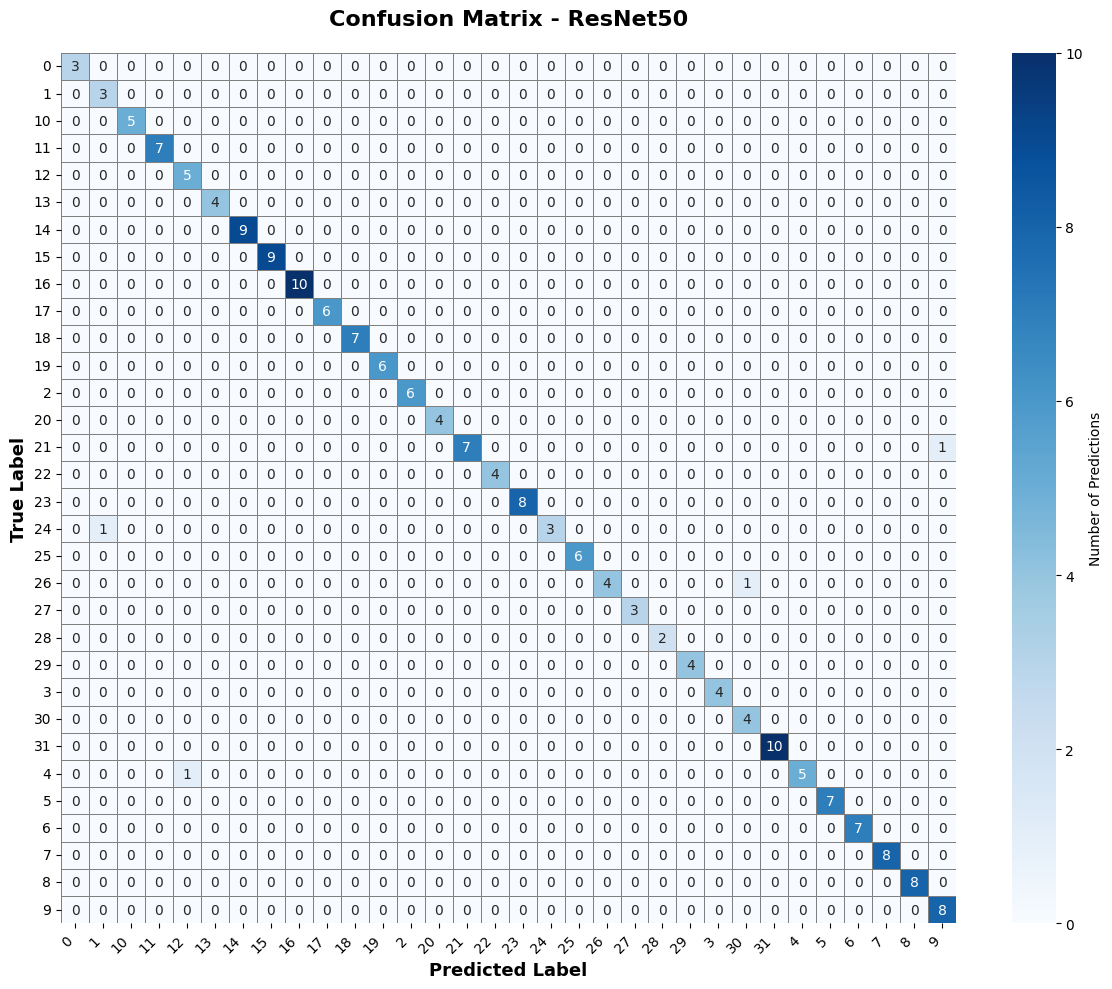

Confusion Matrix Statistics
0: 3/3 correct (100.00%)
1: 3/3 correct (100.00%)
10: 5/5 correct (100.00%)
11: 7/7 correct (100.00%)
12: 5/5 correct (100.00%)
13: 4/4 correct (100.00%)
14: 9/9 correct (100.00%)
15: 9/9 correct (100.00%)
16: 10/10 correct (100.00%)
17: 6/6 correct (100.00%)
18: 7/7 correct (100.00%)
19: 6/6 correct (100.00%)
2: 6/6 correct (100.00%)
20: 4/4 correct (100.00%)
21: 7/8 correct (87.50%)
22: 4/4 correct (100.00%)
23: 8/8 correct (100.00%)
24: 3/4 correct (75.00%)
25: 6/6 correct (100.00%)
26: 4/5 correct (80.00%)
27: 3/3 correct (100.00%)
28: 2/2 correct (100.00%)
29: 4/4 correct (100.00%)
3: 4/4 correct (100.00%)
30: 4/4 correct (100.00%)
31: 10/10 correct (100.00%)
4: 5/6 correct (83.33%)
5: 7/7 correct (100.00%)
6: 7/7 correct (100.00%)
7: 8/8 correct (100.00%)
8: 8/8 correct (100.00%)
9: 8/8 correct (100.00%)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_names = test_dataset.classes

print("Confusion Matrix Shape:", cm.shape)
print("Classes:", class_names)

plt.figure(figsize=(12, 10))

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Number of Predictions'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Confusion Matrix - ResNet50', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

plt.savefig('../Results/Resnet/ResNet50_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()
print("Confusion Matrix Statistics")


for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0

    print(f"{class_name}: {correct}/{total} correct ({accuracy*100:.2f}%)")

ROC Curve and AUC Visualization

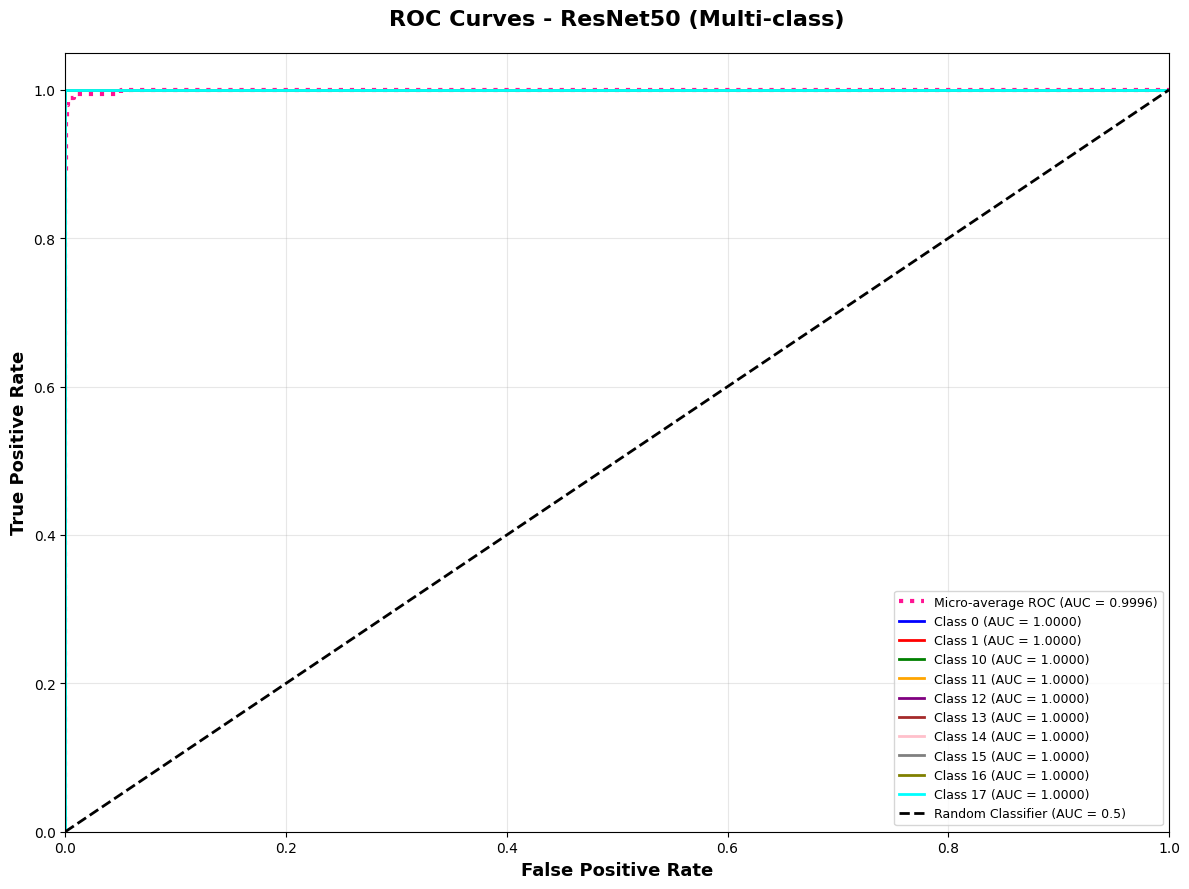

AUC Scores per Class - ResNet50
Micro-average AUC: 0.9996

Class 0: 1.0000
Class 1: 1.0000
Class 10: 1.0000
Class 11: 1.0000
Class 12: 1.0000
Class 13: 1.0000
Class 14: 1.0000
Class 15: 1.0000
Class 16: 1.0000
Class 17: 1.0000
Class 18: 1.0000
Class 19: 1.0000
Class 2: 1.0000
Class 20: 1.0000
Class 21: 0.9993
Class 22: 1.0000
Class 23: 1.0000
Class 24: 1.0000
Class 25: 1.0000
Class 26: 1.0000
Class 27: 1.0000
Class 28: 1.0000
Class 29: 1.0000
Class 3: 1.0000
Class 30: 1.0000
Class 31: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000

Average AUC across all classes: 1.0000


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = len(test_dataset.classes)
class_names = test_dataset.classes

y_true_binary = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12, 9))

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=3)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple',
                'brown', 'pink', 'gray', 'olive', 'cyan'])

num_classes_to_plot = min(10, n_classes)

for i, color in zip(range(num_classes_to_plot), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - ResNet50 (Multi-class)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../Results/Resnet/ResNet50_ROC_curves.png', dpi=300, bbox_inches='tight')

plt.show()


print("AUC Scores per Class - ResNet50")
print("="*50)
print(f"Micro-average AUC: {roc_auc['micro']:.4f}\n")

for i in range(n_classes):
    print(f"Class {class_names[i]}: {roc_auc[i]:.4f}")
print("="*50)

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f"\nAverage AUC across all classes: {avg_auc:.4f}")

Training History Visualization

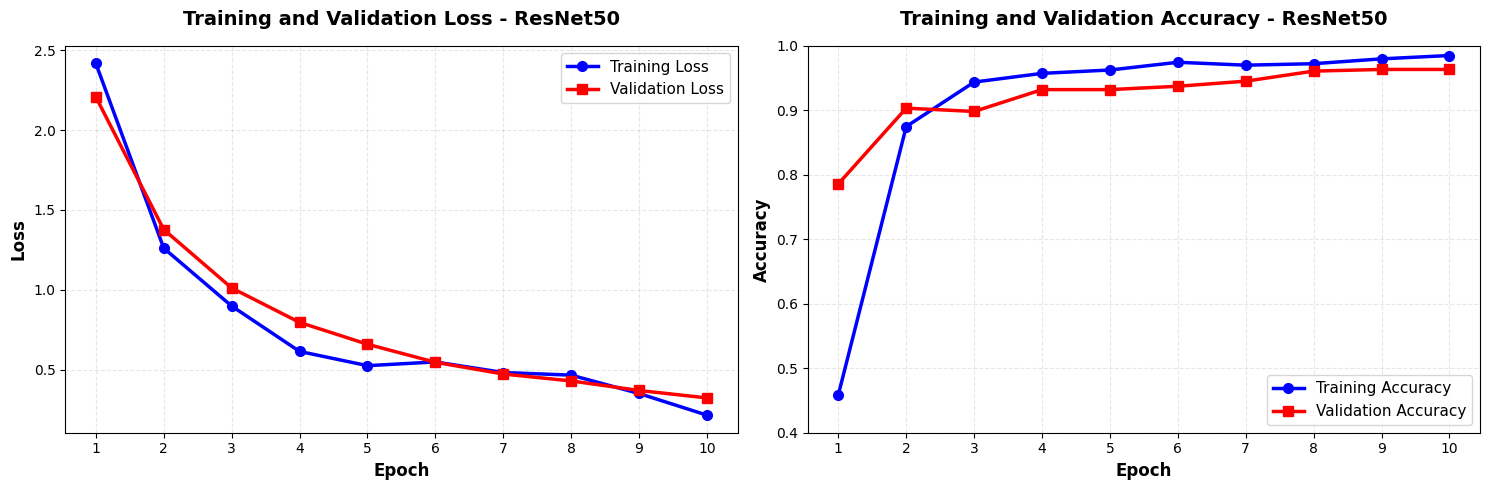

Training Summary - ResNet50
Initial Training Accuracy:    0.4588 (45.88%)
Final Training Accuracy:      0.9850 (98.50%)
Initial Validation Accuracy:  0.7859 (78.59%)
Final Validation Accuracy:    0.9634 (96.34%)

Best Validation Accuracy:     0.9634 (Epoch 9)
Lowest Training Loss:         0.2148 (Epoch 10)
Lowest Validation Loss:       0.3227 (Epoch 10)


In [13]:
history = {
    'train_loss': [2.4182, 1.2610, 0.8984, 0.6140, 0.5247, 0.5481, 0.4819, 0.4654, 0.3504, 0.2148],
    'train_acc': [0.4588, 0.8748, 0.9438, 0.9573, 0.9625, 0.9745, 0.9700, 0.9723, 0.9798, 0.9850],
    'val_loss': [2.2079, 1.3776, 1.0115, 0.7960, 0.6590, 0.5461, 0.4724, 0.4291, 0.3693, 0.3227],
    'val_acc': [0.7859, 0.9034, 0.8982, 0.9321, 0.9321, 0.9373, 0.9452, 0.9608, 0.9634, 0.9634]
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2.5, markersize=7)
ax1.plot(epochs_range, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2.5, markersize=7)
ax1.set_title('Training and Validation Loss - ResNet50', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xticks(epochs_range)

ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2.5, markersize=7)
ax2.plot(epochs_range, history['val_acc'], 'r-s', label='Validation Accuracy', linewidth=2.5, markersize=7)
ax2.set_title('Training and Validation Accuracy - ResNet50', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xticks(epochs_range)
ax2.set_ylim([0.4, 1.0])

plt.tight_layout()
plt.savefig('../Results/Resnet/ResNet50_training_history.png', dpi=300, bbox_inches='tight')

plt.show()

print("Training Summary - ResNet50")
print(f"Initial Training Accuracy:    {history['train_acc'][0]:.4f} ({history['train_acc'][0]*100:.2f}%)")
print(f"Final Training Accuracy:      {history['train_acc'][-1]:.4f} ({history['train_acc'][-1]*100:.2f}%)")
print(f"Initial Validation Accuracy:  {history['val_acc'][0]:.4f} ({history['val_acc'][0]*100:.2f}%)")
print(f"Final Validation Accuracy:    {history['val_acc'][-1]:.4f} ({history['val_acc'][-1]*100:.2f}%)")
print(f"\nBest Validation Accuracy:     {max(history['val_acc']):.4f} (Epoch {history['val_acc'].index(max(history['val_acc']))+1})")
print(f"Lowest Training Loss:         {min(history['train_loss']):.4f} (Epoch {history['train_loss'].index(min(history['train_loss']))+1})")
print(f"Lowest Validation Loss:       {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")